# affine-invariant MCMC package testing (Julia)

In [215]:
using Plots
using BenchmarkTools
using LaTeXStrings
using Distributions
using Statistics
using Printf
using Distributed
import Random: seed!
include("AffineInvariantMCMC.jl")

save_chain (generic function with 1 method)

# Create mock data

The mock data we will create is drawn from the distribution $f$ which has PDF 
$$f(v| v_{esc},k) = \frac{k+1}{v_{esc}{}^{k+1}} (v_{esc} - v)^k \quad,\quad v\in[0,v_{esc}]$$

and CDF
$$ \text{CDF}_f(v) =  \left( 1 - \frac{v}{v_{esc}} \right)^{k+1} -1 \quad,\quad v\in[0,v_{esc}]$$

which has inverse 
$$  \text{CDF}_f{}^{-1}(y) = v_{esc}\left[ 1 - (1-y)^{\frac{1}{k+1}}  \right] \quad,\quad y\in[0,1] $$

We need the inverse CDF to generate samples from this distribution. Note also that the log likelihood is given by
$$ Log\left(\text{Likelihood} (D|v_{esc},k)  \right) = \sum_d Log(f(d|vesc,k)  ) $$

for a dataset D consisting of datapoints $d$, where each term is of the form
$$  Log(f(d|vesc,k)  ) =  Log(k+1) - (k+1)Log(v_{esc}) + k~Log(v_{esc} - v) $$

In [216]:
function powerlaw_PDF(v,x)
    vesc,k = x
    return ( (k+1)*(vesc)^(-k-1) ) * (vesc - v)^k
end

function powerlaw_inverse_CDF(y,x)
    vesc,k = x
    return vesc*( 1.0 - (1.0-y)^( 1.0/(k+1.0) ) )
end

powerlaw_inverse_CDF (generic function with 1 method)

### Define helper functions

In [217]:
function generate_samples(N,inverse_CDF::Function,x)
    # To sample from a distribution we perform inverse transform sampling, for which the inverse CDF is required
    uniform_random_numbers = rand(Float64,N)
    
    return map( num -> inverse_CDF(num,x) , uniform_random_numbers )
end

generate_samples (generic function with 1 method)

### Sample from distribution to obtain data which we will fit via MCMC

We generate data with a specific escape velocity and $k$ to use in our parameter fit later

In [218]:
target_vesc = 550.0
target_k = 3.0
target_x = [target_vesc,target_k]
num_samples = 100000

target_data = generate_samples(num_samples,powerlaw_inverse_CDF,target_x);

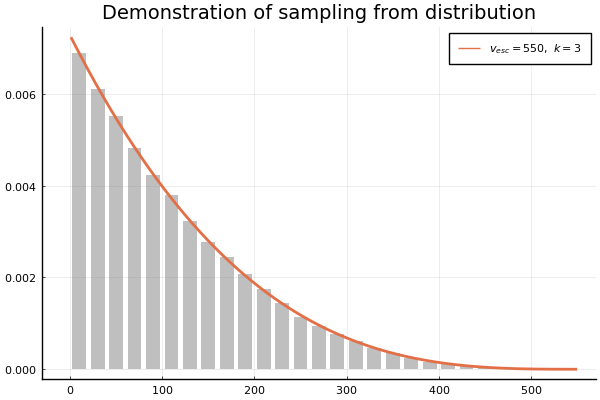

In [219]:
pyplot()

histogram(target_data, normed = true,
                    bins = 25,
                    title = "Demonstration of sampling from distribution",
                    alpha = 0.5,
                    bar_width = 15,
                    linewidth = 0,
                    color = "gray" ,
                    label = ""
                    )

v_test = collect(1:1:550)
plot!(v_test, map(v -> powerlaw_PDF(v,[550.0,3.0]) , v_test) ,
                    linewidth = 2,
                    #color = "red",
                    label = L"v_{esc}=550,~k=3"
                    )

# Define MCMC functions and parameters

In [220]:
function log_prior(x)
    vesc,k = x
    if 100.0 < vesc < 800.0 && 0.2 < k < 10.0 
        return 0.0
    end

    return -Inf
end

function log_likelihood(x,data)
    vesc,k = x
    sum = 0.0
    for v in data
        #println("v = ",v,", vesc = ",vesc)
        if v < vesc && k > 0
            sum += log(k+1.0) - (k+1.0)*log(vesc) + k*log(vesc - v)
        else
            return -Inf 
        end
    end
    return sum
end

function log_probability(x,data)
    return log_likelihood(x,data) + log_prior(x)
end

log_probability (generic function with 1 method)

# Use MCJulia to perform sampling

### Parameters and initial conditions for walkers

In [221]:
# Parameters
ndims = 2
nwalkers = 5
nsamples_perwalker = 2000
burnin = 200
a = 2.0     # affine-invariant MCMC scale parameter (see http://msp.org/camcos/2010/5-1/p04.xhtml) 
thin = 1

# ICs
guess_vesc = 600
guess_k = 4

initial_guess_dist = MvNormal([0.0,0.0],[90 0.0 ; 0.0 0.9])

initial_guess_onewalker = [guess_vesc,guess_k]
initial_guess = copy(transpose(reduce(hcat, [initial_guess_onewalker + vec(rand(initial_guess_dist , 1))  for _ in 1:nwalkers]) ) )

quantile_list = [0.16, 0.5, 0.84];


In [222]:
seed!(0)
S = Sampler(nwalkers, ndims, log_probability, a, (target_data,));

In [223]:
burnin_final_state = sample(S, initial_guess, burnin,thin,false)

Starting serial sampling...


5×2 Matrix{Float64}:
 546.218  2.98232
 548.346  2.98748
 552.201  3.02016
 549.977  2.99799
 549.834  2.99363

In [224]:
@benchmark sample(S, burnin_final_state, nsamples_perwalker, 5, true)  # (sampler, starting point, number of steps, thinning factor for data, store chain?)
#println("acceptance ratio: $(S.accepted / S.iterations)")

Starting serial sampling...
Starting serial sampling...
Starting serial sampling...
Starting serial sampling...


BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 18.265 s (0.00% GC) to evaluate,
 with a memory estimate of 5.30 MiB, over 124205 allocations.

In [225]:
vesc_posterior = flat_chain(S)[1,:];
k_posterior = flat_chain(S)[2,:];

deleteat!(vesc_posterior, vesc_posterior .== 0.0);
deleteat!(k_posterior, k_posterior .== 0.0);

### Process the data

In [226]:
# Establish estimates of parameters via median and expected error on these estimates
vesc_quantiles = quantile(vesc_posterior, quantile_list)
k_quantiles = quantile(k_posterior, quantile_list)


vesc_median = vesc_quantiles[2]
vesc_lower_1sigma = vesc_median - vesc_quantiles[1]
vesc_upper_1sigma = vesc_quantiles[3] - vesc_median

k_median = k_quantiles[2]
k_lower_1sigma = k_median - k_quantiles[1]
k_upper_1sigma = k_quantiles[3] - k_median;

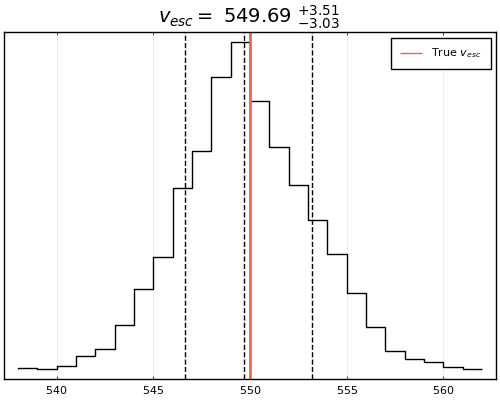

In [227]:
vplot = plot(vesc_posterior, normed = true,
                    bins = 25,
                    title = "\$v_{esc} =\$ $(@sprintf("%.2f", vesc_median)) \$ ^{+$(@sprintf("%.2f", vesc_upper_1sigma))}_{-$(@sprintf("%.2f", vesc_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    framestyle = :box,
                    yticks=false
                    )
vline!([target_vesc], lw = 2, label = L"True $v_{esc}$")

vline!(vesc_quantiles , ls=:dash, color="black",lw=1,label="" )

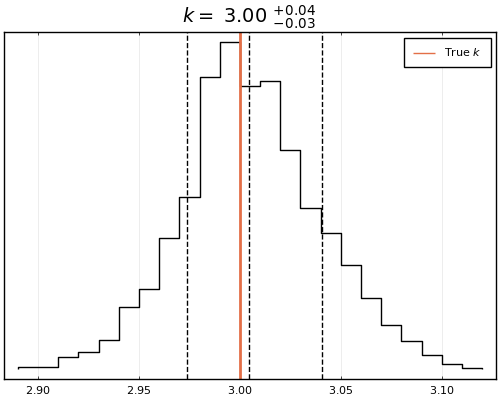

In [228]:
kplot = plot(k_posterior, normed = true,
                    bins = 25,
                    title = "\$k =\$ $(@sprintf("%.2f", k_median)) \$ ^{+$(@sprintf("%.2f", k_upper_1sigma))}_{-$(@sprintf("%.2f", k_lower_1sigma))}\$ ",
                    #alpha = 0.5,
                    #bar_width = 15,
                    #linewidth = 0,
                    #color = "gray" ,
                    lc="black",
                    label = "",
                    seriestype=:stephist,
                    size=(500,400),
                    framestyle = :box,
                    yticks=false
                    )
vline!([target_k], lw = 2, label = L"True $k$")

vline!( k_quantiles, ls=:dash, color="black",lw=1, label="")

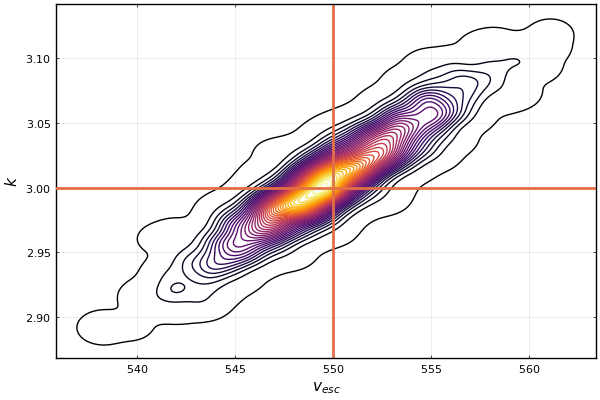

In [239]:
using StatsPlots, KernelDensity
dens = kde((vesc_posterior,k_posterior))
p3 = plot(dens,
    levels = 0.002:0.1:5.0,
    colorbar=false,
    figsize=(400,400),
    xlabel=L"$v_{esc}$",
    ylabel=L"$k$",
    framestyle = :box
    )

vline!([target_vesc], lw = 2,label="")
hline!([target_k], lw = 2,color=2,label="")

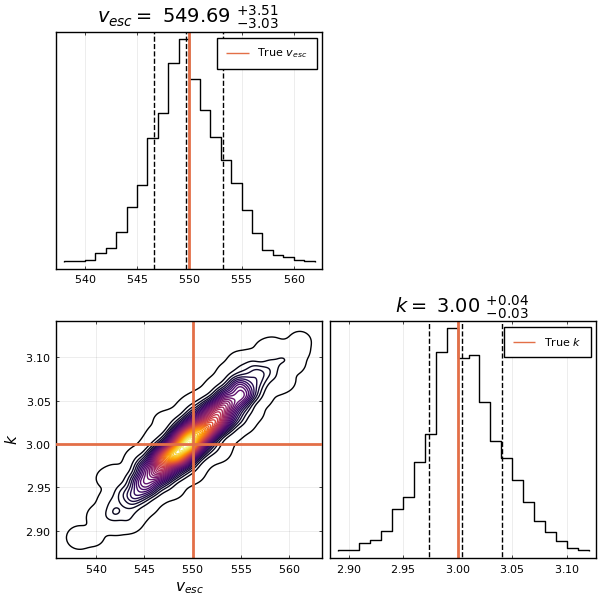

In [240]:
l = @layout [a _ ; b c]

corner = plot(vplot,p3, kplot, layout = l, size=(600,600))

In [241]:
#savefig(corner, "100000_corner_julia_affine.png")